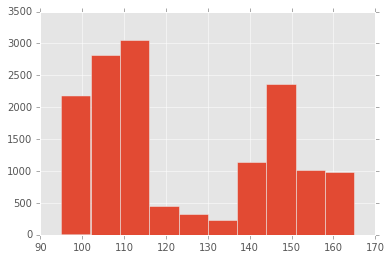

In [137]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
conn = sqlite3.connect("ss.db")
cur  = conn.cursor()

import time
import os

import pandas as pd

qry = """SELECT
bouncepoints_full.ID_Full,
bouncepoints_full.Event,
bouncepoints_full.Range,
bouncepoints_full.EvtDep,
bouncepoints_full.EvtTime,
bouncepoints_full.Azimuth,
bouncepoints_full.MidLat,
bouncepoints_full.MidLon,
snr.SNR
FROM bouncepoints_full 
LEFT JOIN snr
ON bouncepoints_full.ID_Full=snr.ID_Full
WHERE bouncepoints_full.EvtDep < 75
AND ((bouncepoints_full.Range > 95
AND bouncepoints_full.Range < 165))
AND snr.SNR > 1.5
ORDER BY bouncepoints_full.EvtDep
"""

dfds = pd.read_sql_query(qry, conn)

%matplotlib inline
dfbins = pd.read_sql_query("SELECT * from bin_parameters", conn)
dfds.Range.hist()

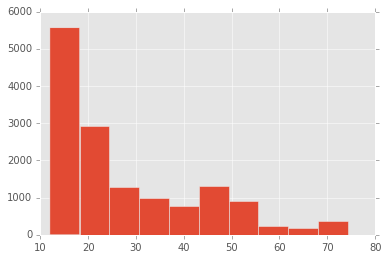

In [138]:
dfds.EvtDep.hist()

In [202]:
arrivals = model.get_travel_times(0,125,["SS","S^410S"])
tref = arrivals[1].time - arrivals[0].time

moveout_correction = []

for each in ranges:
    arr = model.get_travel_times(0,each,["SS","S^410S"])
    t   = arr[1].time - arr[0].time
    moveout_correction.append(t-tref)

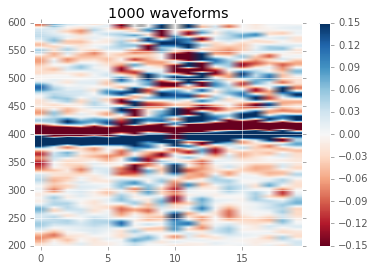

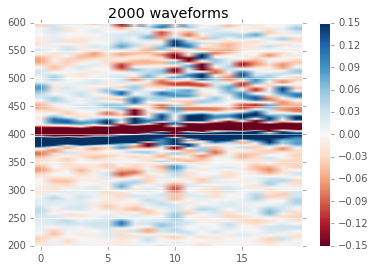

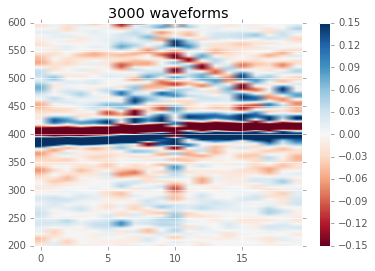

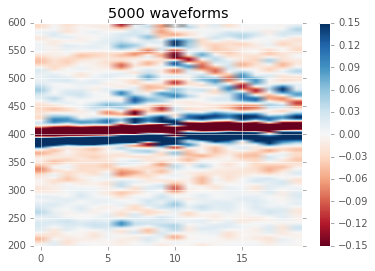

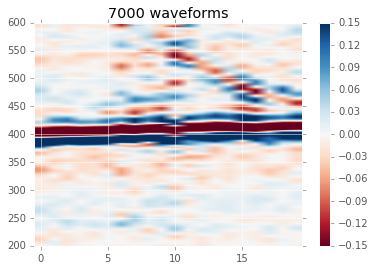

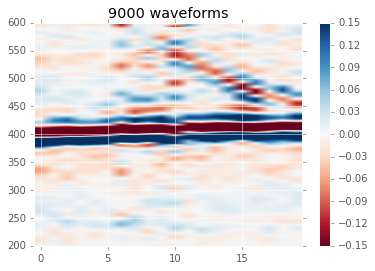

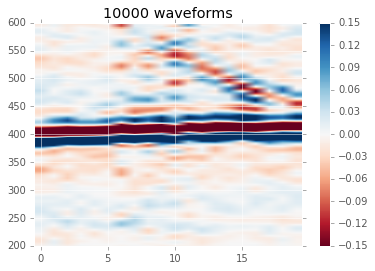

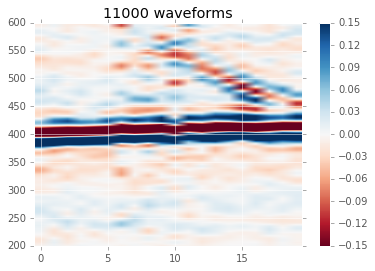

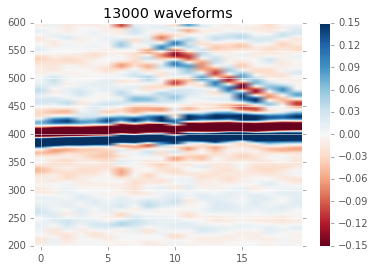

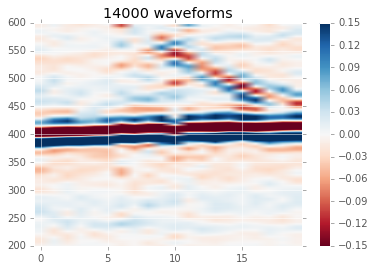

In [203]:
import obspy
from matplotlib import pylab as plt
from numpy import zeros, argmax, nan, sign, arange
from obspy.signal.filter import envelope
from scipy.signal import hilbert

from numpy import nanmean, nanmedian, nanstd, nanmin, nanmax
from numpy.random import choice

from numpy import linspace

st = obspy.Stream()

npts = 800

ngood = 0

shifts = {}
quality = {}

x1, x2 = 95, 165

ranges = linspace(x1, x2, 20)

rbin = zeros(npts*len(ranges)).reshape(npts,len(ranges))
nbin = rbin.copy()


for ii, row in enumerate(dfds.iterrows()):
    bpindex = row[1].ID_Full
    directory = 'data/mseed/%s/' % row[1].Event
    filename = directory + bpindex + '.mseed'
    st0 = obspy.read(filename).detrend('linear').taper(0.05)
    #st0.filter('bandpass',freqmin=0.01,freqmax=0.1,corners=4)
    st0.filter('lowpass',freq=0.03,corners=4,zerophase=False).taper(0.05)
    tr = st0[0]
    tr.data = hilbert(tr.data).imag
    imax = argmax(abs(envelope(tr.data)))
    norm = sign(tr.data[imax])*envelope(tr.data)[imax]
    if imax < 195 or imax > 240:
        shifts[bpindex]  =  imax
        quality[bpindex] = 'bad'
        continue
    else:
        shifts[bpindex]  =  imax
        quality[bpindex] = 'good'
        ngood += 1
    ishift = int(npts/2 - imax) + int(moveout_correction[irange])
    irange = int( (row[1].Range - x1) / (x2 - x1) * len(ranges))
    rbin[ishift:ishift+len(tr.data),irange] += hilbert(-tr.data).imag/norm
    #rbin[ishift:ishift+len(tr.data),irange] += tr.data/norm
    nbin[ishift:ishift+len(tr.data),irange] += 1.0

    if ii%1000 == 0:
        plt.imshow(rbin/nbin,aspect='auto',cmap='RdBu',vmax=0.15,vmin=-0.15)
        plt.ylim([200,600])
        plt.title('%d waveforms' % ii)
        plt.colorbar()
        plt.show()



In [204]:
moveout_correction
    


[-8.1496390718434668,
 -7.1272294321531717,
 -6.096869090365999,
 -5.0813397738431831,
 -4.0647180822438713,
 -3.0692379889062522,
 -2.0732691585883458,
 -1.1054700772033357,
 -0.13524827122955685,
 0.80721212264325004,
 1.7391407426821388,
 2.6573660977173859,
 3.5523351740744147,
 4.4404108191865816,
 5.3092469240677929,
 6.1600572596712482,
 7.0010924188823083,
 7.8268406943793707,
 8.6358112961097504,
 9.4328032125954451]

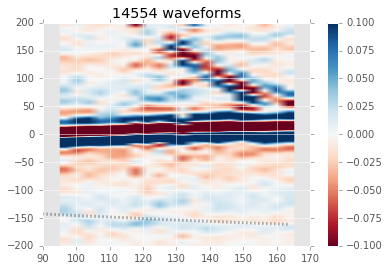

In [205]:
plt.imshow(rbin/nbin,aspect='auto',cmap='RdBu',vmax=0.1,vmin=-0.1, extent = [x1, x2, 400, -400], zorder=0)
plt.ylim([-200,200])
plt.title('%d waveforms' % ii)
plt.colorbar()

from obspy.taup import TauPyModel

model = TauPyModel("prem")

xs = range(90,165)
ts = []

for xdist in range(90,165):
    arrivals = model.get_travel_times(0,xdist,["SS","S^410S"])
    ts.append(- arrivals[1].time + arrivals[0].time)
    
plt.plot(xs,ts,':k',lw=3,zorder=1000,alpha=0.5)

plt.show()


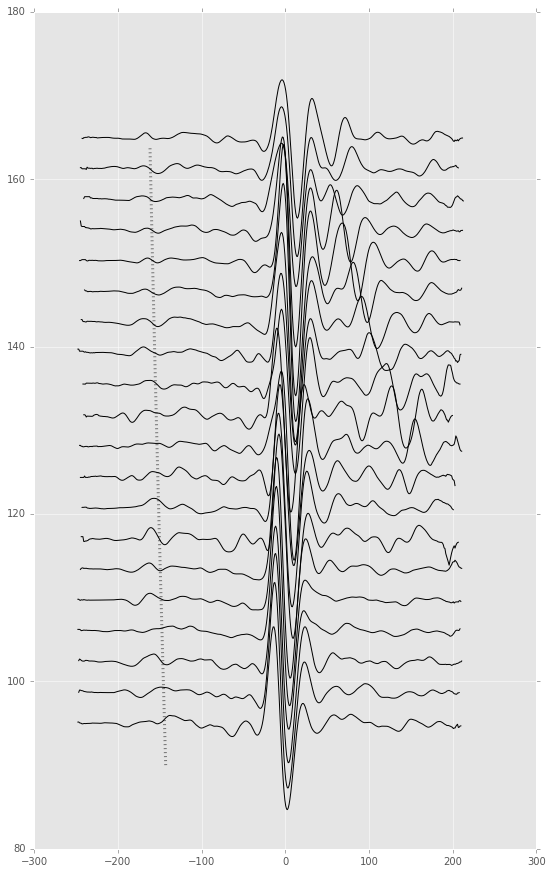

In [206]:

fig = plt.figure(100,figsize=(9,15))

for irange in range(len(ranges)):
    times = linspace(-400,400,len(rbin[:,0]))
    plt.plot(times,rbin[:,irange]*30/nbin[:,irange]+ranges[irange],'k')
    
plt.plot(ts,xs,':k',lw=3,zorder=1000,alpha=0.5)

**Notes**: 